## 1. Importing the Data
Assuming the data files are stored in a local google drive storage, in a folder called "data".

In [ ]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.nn.utils.rnn import pad_sequence
from google.colab import drive
assert torch.cuda.is_available()

drive.mount("/content/gdrive")

train_path = "/content/gdrive/My Drive/data/Constraint_Train.csv"
valid_path = "/content/gdrive/My Drive/data/Constraint_Val.csv"
test_path = "/content/gdrive/My Drive/data/english_test_with_labels.csv"

def get_data(data_path):
    # This is a very large file, so we will not load it into RAM
    return csv.reader(open(data_path, "rt", encoding="utf-8"))

# Printing out some of the lines, to see if the CSV is being read correctly 
for i, line in enumerate(get_data(train_path)):
    if i > 5:
        break
    print(line)

Mounted at /content/gdrive
['id', 'tweet', 'label']
['1', 'The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.', 'real']
['2', 'States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux', 'real']
['3', 'Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag https://t.co/thF8GuNFPe #coronavirus #nashville', 'fake']
['4', '#IndiaFightsCorona: We have 1524 #COVID testing laboratories in India and as on 25th August 2020 36827520 tests have been done : @ProfBhargava DG @ICMRDELHI #StaySafe #IndiaWillWin https://t.co/Yh3ZxknnhZ', 'real']
['5', 'Populous states can generate large case counts but if you look at the new cases per million today 9 smaller states are showing more cases per million than California or Texas: AL AR ID KS KY LA MS NV and SC. https:/

The columns we care about are the second one and the last one. The second column are the social media posts, and the last column is the label indicating whether the post mentions "real" or "fake" news about Covid. Our task is to predict whether a social media post mentions real or fake news about Covid.

We will need to split the text into words.
We will do so by splitting at all whitespace
characters.


In [ ]:
def split_post(post):
    # separate punctuations
    post = post.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return post.lower().split()

## Extracting/Processing Data

Since we are going to store the individual words in a post,
we will defer looking up the word embeddings.
Instead, we will store the **index** of each word in a PyTorch tensor, as it is
more memory efficient.

In [ ]:
def get_post_words(glove_vector, path):
    idxs_li, labels_li = [], []
    ignored_header = False
    for line in get_data(path):
      if not ignored_header:
        ignored_header = True
        continue   # Skipping header line in csv file
      post = line[1]
      if len(post) > 280:  # ignoring input posts longer than the 280 characters 
        continue            # (max size of a post), for efficiency
                                      
      idxs = [glove_vector.stoi[w]        # lookup the index of word
               for w in split_post(post)
               if w in glove_vector.stoi] # keep words that has an embedding
      if not idxs: # ignore posts without any word with an embedding
        continue                       
      idxs = torch.tensor(idxs) # convert list to pytorch tensor
      label = torch.tensor(int(line[2] == "real")).long()
      idxs_li.append(idxs)
      labels_li.append(label)
    return idxs_li, labels_li

# Adding padding to all the data sets
idxs_train, labels_train = get_post_words(glove, train_path)
idxs_train = pad_sequence(idxs_train, batch_first=True)  # Padding
train_data = [[idxs_train[i], labels_train[i]] for i in range(len(labels_train))]

idxs_valid, labels_valid = get_post_words(glove, valid_path)
idxs_valid = pad_sequence(idxs_valid, batch_first=True) # Padding
valid_data = [[idxs_valid[i], labels_valid[i]] for i in range(len(labels_valid))] 

idxs_test, labels_test = get_post_words(glove, test_path)
idxs_test = pad_sequence(idxs_test, batch_first=True) # Padding
test_data = [[idxs_test[i], labels_test[i]] for i in range(len(labels_test))] 

# Printing data set sizes after processing
print("Training dataset size:", len(train_data))
print("Validation dataset size:", len(valid_data))
print("Test dataset size:", len(test_data))

Training dataset size: 5604
Validation dataset size: 1873
Test dataset size: 1848


Here's what an element of the training set looks like:

In [ ]:
post, label = train_data[0]
print(post)
print(label)

tensor([     0,  10423,    839,    687,   1933,      2,      6,    216,      0,
         24840,      6,    336,   4382,    118,    494,   1099,     32,    357,
             5, 156629,      2,      0,    336,   2493,   2577,     22,   3208,
        236671,     69,    373,      2,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0])
tensor(1)


# Building the Transformer Model
Here we build the components of the Transformer Encoder, and in the end encapsulate the layers into a final Transformer Model

## Input Embedding

We are also going to use an `nn.Embedding` layer, instead of using the variable
`glove` directly. The reason is that the `nn.Embedding` layer lets us look up
the embeddings of **multiple words** simultaneously, so that our network
can make predictions and train faster:

In [ ]:
# Create an `nn.Embedding` layer and load data from pretrained `glove.vectors`
glove_emb = nn.Embedding.from_pretrained(glove.vectors)
print(post)
# Example: we use the forward function of glove_emb to lookup the
# embedding of each word in "post"
post_emb = glove_emb(post)
print(post_emb)

tensor([     0,  10423,    839,    687,   1933,      2,      6,    216,      0,
         24840,      6,    336,   4382,    118,    494,   1099,     32,    357,
             5, 156629,      2,      0,    336,   2493,   2577,     22,   3208,
        236671,     69,    373,      2,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0])
tensor([[ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        [ 1.0754, -0.8692,  0.5887,  ...,  0.9364,  0.4252,  1.4567],
        [ 0.1419,  0.3410,  0.2213,  ...,  0.2460, -0.4449,  0.1761],
        ...,
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        [ 0.4180,  0

This tensor is a representation of the entire post,
and will be used as an input to our classifier.

## Positional Encoding

In [ ]:
# Creating Positional Encoding Layer using code from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
  def __init__(self, emb_size, dropout = 0.1, max_len = 5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, emb_size, 2) * (-math.log(10000.0) / emb_size))
    pe = torch.zeros(max_len, 1, emb_size)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:x.size(0)]
    x = self.dropout(x)
    return x

##  Transformer Model

In [ ]:
class Transformer(nn.Module):
    def __init__(self, emb_size, dim_feedforward = 2048, num_layers = 2, dropout_pos = 0.1, dropout_encoder = 0.1):
        super(Transformer, self).__init__()
        self.emb_size = emb_size
        self.emb = nn.Embedding.from_pretrained(glove.vectors, freeze=True)
        self.pos_encode = PositionalEncoding(emb_size, dropout = dropout_pos)
        self.encoder_layers = nn.TransformerEncoderLayer(emb_size, 5, dim_feedforward = dim_feedforward, 
                                                         batch_first=True, dropout = dropout_encoder)
        self.encode = nn.TransformerEncoder(self.encoder_layers, num_layers)
        self.linear = nn.Linear(emb_size, 2)
    
    def forward(self, x):
        mask = (x == 0)
        x = self.emb(x.cuda()) * math.sqrt(self.emb_size)
        x = self.pos_encode(x.cuda())
        x = self.encode(x.cuda(), src_key_padding_mask = mask)
        x = x.mean(dim=1)
        out = self.linear(x.cuda())
        return out

##  Training Functions

In [ ]:
def get_accuracy(model, data):
    loader = torch.utils.data.DataLoader(data, batch_size=256)
    correct, total = 0, 0
    model.eval()
    for posts, labels in loader:
        posts = posts.cuda()
        labels = labels.cuda()

        output = model(posts)
        pred = output.argmax(1)
        correct += pred.eq(labels).sum().item()
        total += labels.shape[0]
    return correct / total

In [ ]:
def train_network(model, train_data, valid_data, batch_size = 32, num_epochs=5, learning_rate=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    train = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    valid = torch.utils.data.DataLoader(valid_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    
    checkpoint_path = '/content/gdrive/My Drive/checkpointing/ckpt-{}.pk'
    
    model = model.cuda()
    model.train()
    # Training
    for epoch in range(num_epochs):
        for posts, labels in train:
            posts = posts.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()
            pred = model(posts)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_data))
        valid_acc.append(get_accuracy(model, valid_data))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
        
        # Checkpointing
        # print("Saving Model........")
        torch.save(model.state_dict(), checkpoint_path.format(epoch)) 

    # Plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

## Overfit to a Small Dataset

Epoch 1; Loss 0.593686; Train Acc 0.720000; Val Acc 0.720000
Epoch 2; Loss 1.058269; Train Acc 0.720000; Val Acc 0.720000
Epoch 3; Loss 0.636090; Train Acc 0.760000; Val Acc 0.760000
Epoch 4; Loss 0.364439; Train Acc 0.940000; Val Acc 0.940000
Epoch 5; Loss 0.251988; Train Acc 0.940000; Val Acc 0.940000
Epoch 6; Loss 0.254728; Train Acc 0.980000; Val Acc 0.980000
Epoch 7; Loss 0.176244; Train Acc 1.000000; Val Acc 1.000000
Epoch 8; Loss 0.048285; Train Acc 1.000000; Val Acc 1.000000
Epoch 9; Loss 0.030777; Train Acc 1.000000; Val Acc 1.000000
Epoch 10; Loss 0.038201; Train Acc 1.000000; Val Acc 1.000000
Epoch 11; Loss 0.012006; Train Acc 1.000000; Val Acc 1.000000
Epoch 12; Loss 0.004983; Train Acc 1.000000; Val Acc 1.000000
Epoch 13; Loss 0.005259; Train Acc 1.000000; Val Acc 1.000000
Epoch 14; Loss 0.003409; Train Acc 1.000000; Val Acc 1.000000
Epoch 15; Loss 0.002709; Train Acc 1.000000; Val Acc 1.000000
Epoch 16; Loss 0.002324; Train Acc 1.000000; Val Acc 1.000000
Epoch 17; Loss 0.

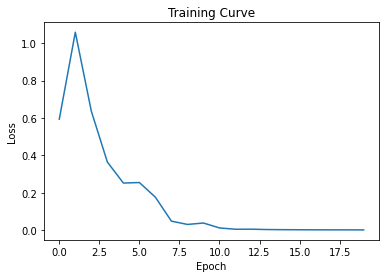

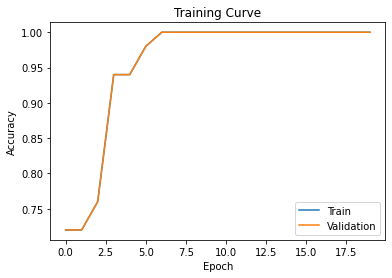

In [ ]:
# Initial testing to see if model/training works
train_data_subset = torch.utils.data.Subset(train_data, np.random.choice(len(train_data), 50, replace=False))
model = Transformer(50, 2).cuda()
train_network(model, train_data_subset, train_data_subset, batch_size = 20, num_epochs=20, learning_rate=0.003)
# Note here the validation and training accuracy will be the same since the same dataset is passsed in for both parameters 

## Test if Working on Entire Dataset

Epoch 1; Loss 0.618732; Train Acc 0.725018; Val Acc 0.735184
Epoch 2; Loss 0.481036; Train Acc 0.802463; Val Acc 0.793914
Epoch 3; Loss 0.359928; Train Acc 0.821199; Val Acc 0.826482
Epoch 4; Loss 0.395581; Train Acc 0.849036; Val Acc 0.834490
Epoch 5; Loss 0.356034; Train Acc 0.853854; Val Acc 0.853711
Epoch 6; Loss 0.325188; Train Acc 0.869022; Val Acc 0.855312
Epoch 7; Loss 0.303962; Train Acc 0.873840; Val Acc 0.866524
Epoch 8; Loss 0.244219; Train Acc 0.883833; Val Acc 0.872931
Epoch 9; Loss 0.239191; Train Acc 0.888829; Val Acc 0.871863
Epoch 10; Loss 0.251982; Train Acc 0.890971; Val Acc 0.884677
Epoch 11; Loss 0.255554; Train Acc 0.894897; Val Acc 0.873999
Epoch 12; Loss 0.228943; Train Acc 0.905782; Val Acc 0.893753
Epoch 13; Loss 0.253564; Train Acc 0.911849; Val Acc 0.894821
Epoch 14; Loss 0.216516; Train Acc 0.917380; Val Acc 0.890016
Epoch 15; Loss 0.232046; Train Acc 0.920414; Val Acc 0.899092
Epoch 16; Loss 0.208921; Train Acc 0.908994; Val Acc 0.895355
Epoch 17; Loss 0.

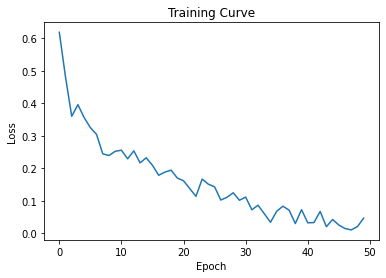

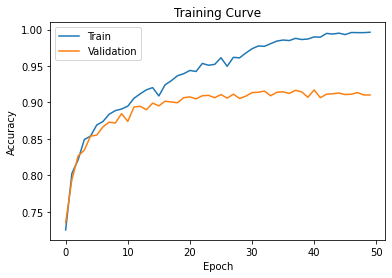

In [ ]:
model = Transformer(50).cuda()
train_network(model, train_data, valid_data, batch_size = 512, num_epochs=50, learning_rate=2e-4)

# Hyperparameter Tuning

Epoch 1; Loss 0.662430; Train Acc 0.641328; Val Acc 0.669514
Epoch 2; Loss 0.567153; Train Acc 0.741435; Val Acc 0.752803
Epoch 3; Loss 0.495661; Train Acc 0.766774; Val Acc 0.772557
Epoch 4; Loss 0.442044; Train Acc 0.799251; Val Acc 0.799786
Epoch 5; Loss 0.444437; Train Acc 0.817452; Val Acc 0.815804
Epoch 6; Loss 0.380095; Train Acc 0.835832; Val Acc 0.834490
Epoch 7; Loss 0.322434; Train Acc 0.843862; Val Acc 0.844100
Epoch 8; Loss 0.363260; Train Acc 0.852784; Val Acc 0.856380
Epoch 9; Loss 0.369576; Train Acc 0.861349; Val Acc 0.860117
Epoch 10; Loss 0.308193; Train Acc 0.867773; Val Acc 0.866524
Epoch 11; Loss 0.269740; Train Acc 0.875446; Val Acc 0.868126
Epoch 12; Loss 0.294537; Train Acc 0.880799; Val Acc 0.870796
Epoch 13; Loss 0.242080; Train Acc 0.884547; Val Acc 0.868126
Epoch 14; Loss 0.246434; Train Acc 0.889186; Val Acc 0.871863
Epoch 15; Loss 0.299608; Train Acc 0.894540; Val Acc 0.878270
Epoch 16; Loss 0.221086; Train Acc 0.896502; Val Acc 0.872931
Epoch 17; Loss 0.

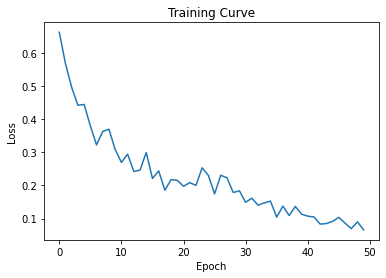

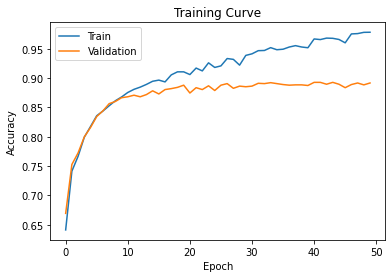

In [ ]:
model = Transformer(50).cuda()
train_network(model, train_data, valid_data, batch_size = 512, num_epochs=50, learning_rate=1e-4)

Epoch 1; Loss 0.603379; Train Acc 0.829408; Val Acc 0.817939
Epoch 2; Loss 0.230217; Train Acc 0.862420; Val Acc 0.856914
Epoch 3; Loss 0.324370; Train Acc 0.877944; Val Acc 0.868660
Epoch 4; Loss 0.189075; Train Acc 0.888473; Val Acc 0.872931
Epoch 5; Loss 0.267516; Train Acc 0.901856; Val Acc 0.888414
Epoch 6; Loss 0.529546; Train Acc 0.891863; Val Acc 0.872397
Epoch 7; Loss 0.022195; Train Acc 0.914347; Val Acc 0.900160
Epoch 8; Loss 0.019145; Train Acc 0.925232; Val Acc 0.905499
Epoch 9; Loss 0.089620; Train Acc 0.934868; Val Acc 0.899092
Epoch 10; Loss 0.021159; Train Acc 0.923804; Val Acc 0.899092
Epoch 11; Loss 0.028659; Train Acc 0.952534; Val Acc 0.906567
Epoch 12; Loss 0.023044; Train Acc 0.947894; Val Acc 0.907101
Epoch 13; Loss 0.021686; Train Acc 0.912919; Val Acc 0.873999
Epoch 14; Loss 0.033543; Train Acc 0.938615; Val Acc 0.894821
Epoch 15; Loss 0.013091; Train Acc 0.943790; Val Acc 0.895889
Epoch 16; Loss 0.174627; Train Acc 0.972698; Val Acc 0.902296
Epoch 17; Loss 1.

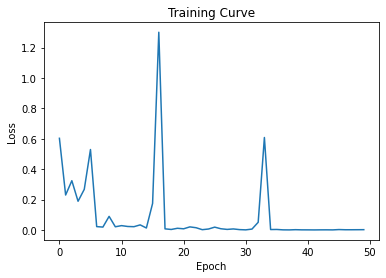

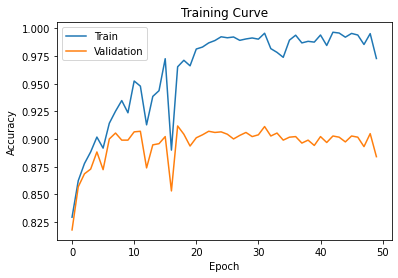

In [ ]:
model = Transformer(50).cuda()
train_network(model, train_data, valid_data, batch_size = 100, num_epochs=50, learning_rate=2e-4)

Epoch 1; Loss 0.721622; Train Acc 0.508922; Val Acc 0.506140
Epoch 2; Loss 0.690972; Train Acc 0.508922; Val Acc 0.506140
Epoch 3; Loss 0.687290; Train Acc 0.509101; Val Acc 0.506140
Epoch 4; Loss 0.666188; Train Acc 0.774625; Val Acc 0.781100
Epoch 5; Loss 0.439670; Train Acc 0.816203; Val Acc 0.811532
Epoch 6; Loss 0.344043; Train Acc 0.863490; Val Acc 0.850507
Epoch 7; Loss 0.294488; Train Acc 0.883655; Val Acc 0.864389
Epoch 8; Loss 0.296965; Train Acc 0.906674; Val Acc 0.882007
Epoch 9; Loss 0.263409; Train Acc 0.918273; Val Acc 0.886279
Epoch 10; Loss 0.234826; Train Acc 0.916131; Val Acc 0.884143
Epoch 11; Loss 0.230537; Train Acc 0.931299; Val Acc 0.890016
Epoch 12; Loss 0.216208; Train Acc 0.930228; Val Acc 0.884677
Epoch 13; Loss 0.181262; Train Acc 0.950214; Val Acc 0.900694
Epoch 14; Loss 0.192971; Train Acc 0.952355; Val Acc 0.891618
Epoch 15; Loss 0.148490; Train Acc 0.968415; Val Acc 0.903364
Epoch 16; Loss 0.110398; Train Acc 0.974304; Val Acc 0.901762
Epoch 17; Loss 0.

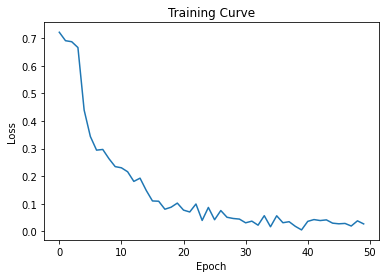

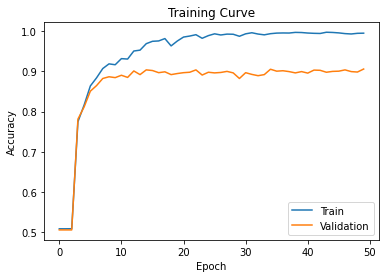

In [ ]:
model = Transformer(50).cuda()
train_network(model, train_data, valid_data, batch_size = 512, num_epochs=50, learning_rate=2e-3)

100%|█████████▉| 399999/400000 [00:15<00:00, 25065.24it/s]


Epoch 1; Loss 0.606626; Train Acc 0.733048; Val Acc 0.730913
Epoch 2; Loss 0.464674; Train Acc 0.799429; Val Acc 0.790710
Epoch 3; Loss 0.361335; Train Acc 0.845111; Val Acc 0.849973
Epoch 4; Loss 0.329470; Train Acc 0.870985; Val Acc 0.859584
Epoch 5; Loss 0.281582; Train Acc 0.882049; Val Acc 0.862787
Epoch 6; Loss 0.274132; Train Acc 0.895075; Val Acc 0.880940
Epoch 7; Loss 0.269596; Train Acc 0.907209; Val Acc 0.882541
Epoch 8; Loss 0.243882; Train Acc 0.915418; Val Acc 0.891084
Epoch 9; Loss 0.188199; Train Acc 0.924518; Val Acc 0.898025
Epoch 10; Loss 0.180107; Train Acc 0.924518; Val Acc 0.892152
Epoch 11; Loss 0.194874; Train Acc 0.945396; Val Acc 0.905499
Epoch 12; Loss 0.193992; Train Acc 0.954675; Val Acc 0.908703
Epoch 13; Loss 0.122393; Train Acc 0.960207; Val Acc 0.909770
Epoch 14; Loss 0.125910; Train Acc 0.963776; Val Acc 0.914042
Epoch 15; Loss 0.086164; Train Acc 0.974304; Val Acc 0.912974
Epoch 16; Loss 0.074600; Train Acc 0.977516; Val Acc 0.910838
Epoch 17; Loss 0.

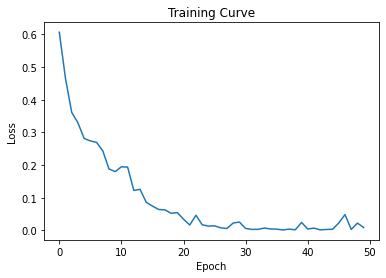

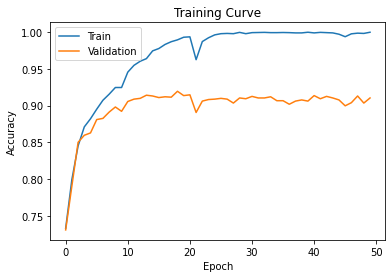

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=100)

model = Transformer(100).cuda()
train_network(model, train_data, valid_data, batch_size = 512, num_epochs=50, learning_rate=2e-4)

Epoch 1; Loss 0.654704; Train Acc 0.689329; Val Acc 0.693006
Epoch 2; Loss 0.722337; Train Acc 0.772484; Val Acc 0.768820
Epoch 3; Loss 0.180373; Train Acc 0.812455; Val Acc 0.816337
Epoch 4; Loss 0.177508; Train Acc 0.833333; Val Acc 0.832355
Epoch 5; Loss 0.140599; Train Acc 0.841006; Val Acc 0.830219
Epoch 6; Loss 0.921190; Train Acc 0.795682; Val Acc 0.785905
Epoch 7; Loss 0.189782; Train Acc 0.849036; Val Acc 0.853711
Epoch 8; Loss 0.385022; Train Acc 0.867773; Val Acc 0.865456
Epoch 9; Loss 0.272811; Train Acc 0.879907; Val Acc 0.868660
Epoch 10; Loss 0.346809; Train Acc 0.885439; Val Acc 0.869728
Epoch 11; Loss 0.500374; Train Acc 0.873305; Val Acc 0.862253
Epoch 12; Loss 0.156995; Train Acc 0.862598; Val Acc 0.849439
Epoch 13; Loss 0.191498; Train Acc 0.887045; Val Acc 0.868660
Epoch 14; Loss 0.460623; Train Acc 0.894540; Val Acc 0.876668
Epoch 15; Loss 0.119889; Train Acc 0.897038; Val Acc 0.876135
Epoch 16; Loss 0.423029; Train Acc 0.896859; Val Acc 0.882541
Epoch 17; Loss 0.

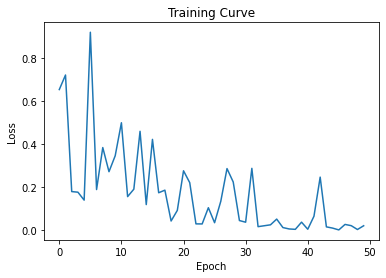

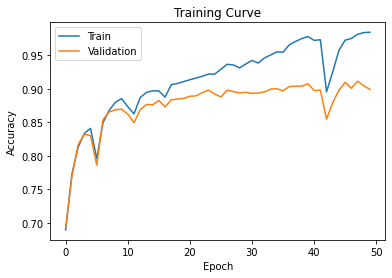

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=50)

model = Transformer(50).cuda()
train_network(model, train_data, valid_data, batch_size = 350, num_epochs=50, learning_rate=2e-4)

Epoch 1; Loss 0.689933; Train Acc 0.548537; Val Acc 0.543513
Epoch 2; Loss 0.672504; Train Acc 0.625803; Val Acc 0.614522
Epoch 3; Loss 0.647038; Train Acc 0.680764; Val Acc 0.661506
Epoch 4; Loss 0.631611; Train Acc 0.713241; Val Acc 0.694074
Epoch 5; Loss 0.618223; Train Acc 0.740186; Val Acc 0.719167
Epoch 6; Loss 0.582881; Train Acc 0.756959; Val Acc 0.737854
Epoch 7; Loss 0.570189; Train Acc 0.767844; Val Acc 0.754405
Epoch 8; Loss 0.553642; Train Acc 0.774268; Val Acc 0.753337
Epoch 9; Loss 0.528205; Train Acc 0.782834; Val Acc 0.768286
Epoch 10; Loss 0.500484; Train Acc 0.790328; Val Acc 0.776829
Epoch 11; Loss 0.458205; Train Acc 0.796217; Val Acc 0.783769
Epoch 12; Loss 0.467597; Train Acc 0.801035; Val Acc 0.793380
Epoch 13; Loss 0.447716; Train Acc 0.807637; Val Acc 0.804592
Epoch 14; Loss 0.463254; Train Acc 0.812991; Val Acc 0.809397
Epoch 15; Loss 0.378181; Train Acc 0.818701; Val Acc 0.823812
Epoch 16; Loss 0.437358; Train Acc 0.823876; Val Acc 0.827549
Epoch 17; Loss 0.

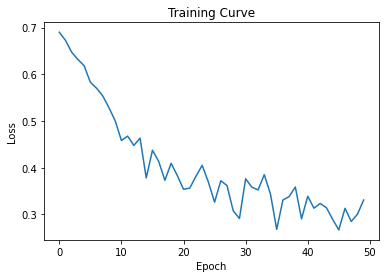

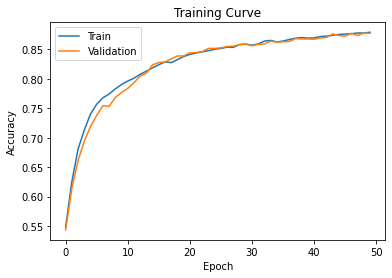

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=50)

model = Transformer(50).cuda()
train_network(model, train_data, valid_data, batch_size = 512, num_epochs=50, learning_rate=2e-5)

100%|█████████▉| 399999/400000 [00:38<00:00, 10466.21it/s]


Epoch 1; Loss 0.582342; Train Acc 0.725553; Val Acc 0.714896
Epoch 2; Loss 0.367320; Train Acc 0.841899; Val Acc 0.827549
Epoch 3; Loss 0.289710; Train Acc 0.887045; Val Acc 0.869194
Epoch 4; Loss 0.246769; Train Acc 0.907923; Val Acc 0.879338
Epoch 5; Loss 0.246298; Train Acc 0.930942; Val Acc 0.897491
Epoch 6; Loss 0.154612; Train Acc 0.948430; Val Acc 0.908169
Epoch 7; Loss 0.106439; Train Acc 0.962170; Val Acc 0.910304
Epoch 8; Loss 0.099253; Train Acc 0.977159; Val Acc 0.914576
Epoch 9; Loss 0.085501; Train Acc 0.987866; Val Acc 0.914042
Epoch 10; Loss 0.053384; Train Acc 0.991970; Val Acc 0.914042
Epoch 11; Loss 0.026607; Train Acc 0.995360; Val Acc 0.917779
Epoch 12; Loss 0.020731; Train Acc 0.996788; Val Acc 0.915643
Epoch 13; Loss 0.008345; Train Acc 0.996788; Val Acc 0.911372
Epoch 14; Loss 0.006701; Train Acc 0.997859; Val Acc 0.915643
Epoch 15; Loss 0.002726; Train Acc 0.999465; Val Acc 0.918313
Epoch 16; Loss 0.004130; Train Acc 0.999108; Val Acc 0.910838
Epoch 17; Loss 0.

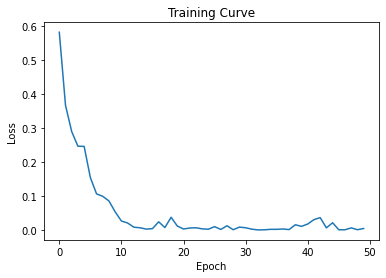

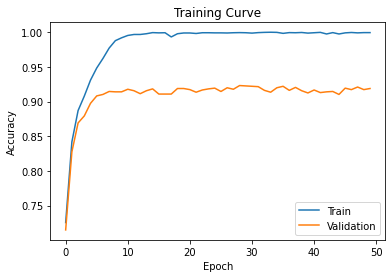

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=300)

model = Transformer(300).cuda()
train_network(model, train_data, valid_data, batch_size = 512, num_epochs=50, learning_rate=2e-4)

Epoch 1; Loss 0.744703; Train Acc 0.508922; Val Acc 0.506140
Epoch 2; Loss 0.699941; Train Acc 0.491078; Val Acc 0.493860
Epoch 3; Loss 0.695198; Train Acc 0.508922; Val Acc 0.506140
Epoch 4; Loss 0.689438; Train Acc 0.742862; Val Acc 0.725040
Epoch 5; Loss 0.677176; Train Acc 0.720914; Val Acc 0.730913
Epoch 6; Loss 0.487524; Train Acc 0.812099; Val Acc 0.797117
Epoch 7; Loss 0.359105; Train Acc 0.859565; Val Acc 0.847304
Epoch 8; Loss 0.361208; Train Acc 0.881513; Val Acc 0.852109
Epoch 9; Loss 0.266175; Train Acc 0.899893; Val Acc 0.864389
Epoch 10; Loss 0.325049; Train Acc 0.918808; Val Acc 0.877202
Epoch 11; Loss 0.263693; Train Acc 0.912027; Val Acc 0.872931
Epoch 12; Loss 0.195186; Train Acc 0.920949; Val Acc 0.861185
Epoch 13; Loss 0.215853; Train Acc 0.938615; Val Acc 0.878270
Epoch 14; Loss 0.173559; Train Acc 0.948965; Val Acc 0.880406
Epoch 15; Loss 0.160708; Train Acc 0.955032; Val Acc 0.876135
Epoch 16; Loss 0.158647; Train Acc 0.964311; Val Acc 0.879338
Epoch 17; Loss 0.

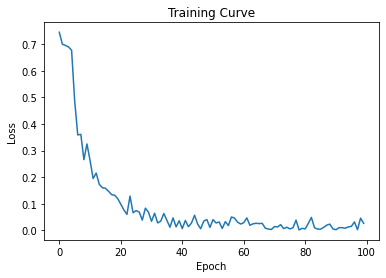

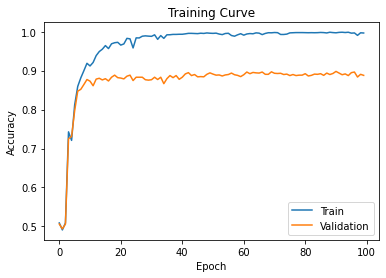

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=50)

model = Transformer(50).cuda()
train_network(model, train_data, valid_data, batch_size = 512, num_epochs=100, learning_rate=2e-3)

Epoch 1; Loss 0.490149; Train Acc 0.809422; Val Acc 0.815804
Epoch 2; Loss 0.409235; Train Acc 0.859208; Val Acc 0.853711
Epoch 3; Loss 0.253351; Train Acc 0.887580; Val Acc 0.876668
Epoch 4; Loss 0.209999; Train Acc 0.913990; Val Acc 0.896957
Epoch 5; Loss 0.170127; Train Acc 0.933619; Val Acc 0.900694
Epoch 6; Loss 0.159220; Train Acc 0.948073; Val Acc 0.907635
Epoch 7; Loss 0.109413; Train Acc 0.967166; Val Acc 0.918313
Epoch 8; Loss 0.105485; Train Acc 0.978051; Val Acc 0.920448
Epoch 9; Loss 0.096615; Train Acc 0.986617; Val Acc 0.917779
Epoch 10; Loss 0.024777; Train Acc 0.991792; Val Acc 0.918313
Epoch 11; Loss 0.015384; Train Acc 0.998037; Val Acc 0.917245
Epoch 12; Loss 0.011698; Train Acc 0.998394; Val Acc 0.916711
Epoch 13; Loss 0.004004; Train Acc 0.999465; Val Acc 0.917779
Epoch 14; Loss 0.004631; Train Acc 0.999822; Val Acc 0.914576
Epoch 15; Loss 0.002741; Train Acc 0.999108; Val Acc 0.916177
Epoch 16; Loss 0.004893; Train Acc 0.998929; Val Acc 0.918313
Epoch 17; Loss 0.

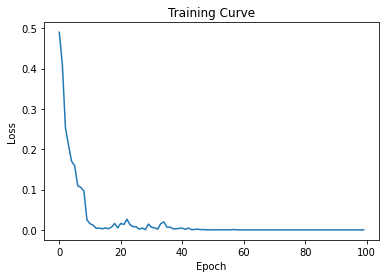

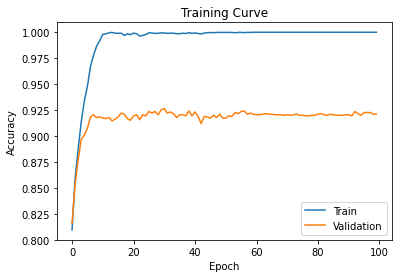

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=300)

model = Transformer(300).cuda()
train_network(model, train_data, valid_data, batch_size = 512, num_epochs=100, learning_rate=2e-4)

# Final Model Predictions and Performance Metrics

## Final Model and Accuracies


From our hyperparameter tuning, we choose the model right above, which has the glove embeddings with size 300, and we chose the weights at checkpoint 57 (path is at checkpoint 56 because of 0 indexing), as it has the highest validation accuracy.

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=300)
model = Transformer(300).cuda()
model.load_state_dict(torch.load('/content/gdrive/My Drive/checkpointing/ckpt-56.pk'))
print('Train accuracy of the Transformer Model is: %f' % (get_accuracy(model, train_data)))
print('Validation accuracy of the Transformer Model is: %f' % (get_accuracy(model, valid_data)))
print('Test accuracy of the Transformer Model is: %f' % (get_accuracy(model, test_data)))

100%|█████████▉| 399999/400000 [00:37<00:00, 10597.81it/s]


Train accuracy of the Transformer Model is: 0.999643
Validation accuracy of the Transformer Model is: 0.924186
Test accuracy of the Transformer Model is: 0.912879


## Finding one image that was classified correctly and one that was classified incorrectly in the test set

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)
model.eval()
found_correct = False
found_incorrect = False


for post, label in test_loader:
  post = post.cuda()
  label = label.cuda()
  output = model(post)
  pred = output.argmax(1).item()
  label = label.item()
  if pred == label and not found_correct:
    correct_post = post.tolist()[0] 
    found_correct = True
  if pred != label and not found_incorrect:
    incorrect_post = post.tolist()[0] 
    found_incorrect = True
  if found_correct and found_incorrect:
    break

correct_post_words = [glove.itos[w] for w in list(filter(lambda a: a != 0, correct_post))]
print("Correctly classified processed post in test set: ", correct_post_words)
incorrect_post_words = [glove.itos[w] for w in list(filter(lambda a: a != 0, incorrect_post))]
print("Incorrectly classified processed post in test set: ", incorrect_post_words)


Correctly classified processed post in test set:  ['our', 'daily', 'update', 'is', 'published', '.', 'states', 'reported', 'tests', 'new', 'cases', 'and', '532', 'deaths', '.', 'current', 'hospitalizations', 'fell', 'below', '30k', 'for', 'first', 'time', 'since', 'june', '22', '.', '.']
Incorrectly classified processed post in test set:  ['two', 'interesting', 'children', 'tend', 'to', 'weather', 'pretty', 'well', ';', 'they', 'also', 'get', 'a', 'ton', 'of', 'vitamin', 'd', '.', 'black', 'people', 'are', 'getting', 'slammed', 'by', ';', 'black', 'people', 'also', 'have', 'much', 'higher', 'instances', 'of', 'vitamin', 'd', 'deficiency', 'vs', 'in', 'general', '.']


Note from above's code the correctly classified pre-processed post is post #1 in the test set, which is: "Our daily update is published. States reported 734k tests 39k new cases and 532 deaths. Current hospitalizations fell below 30k for the first time since June 22. https://t.co/wzSYMe0Sht". This had label real, which our model correctly classified.



The incorrectly classified pre-processed post from above's code is post #11 in the test set, which is: "Two interesting correlations:

1) Children tend to weather COVID-19 pretty well; they also get a ton of Vitamin D.

2) Black people are getting slammed by COVID-19; black people also have much higher instances of Vitamin D deficiency (76% vs 40% in the general population).". This had label fake, but our model misclassified it as real.

## More Final Model Measures

Getting the True Positive Rate (TPR), True Negative Rate (TNR), Positive Predictive Value (PPV), Negative Predictve Value (NPV) values on the test set.

In [ ]:
def get_TP_TN_FP_FN(model, data):
    '''
    TP = true positive
    TN = true negative
    FP = false positive
    FN = false negative
    '''
    loader = torch.utils.data.DataLoader(data, batch_size=256)
    TP_tot, TN_tot, FP_tot, FN_tot = 0, 0, 0, 0
    model.eval()
    for posts, labels in loader:
        posts = posts.cuda()
        labels = labels.cuda()

        output = model(posts)
        pred = output.argmax(1)
        
        ones = torch.ones(pred.shape)
        zeros = torch.zeros(pred.shape)
        ones = ones.cuda()
        zeros = zeros.cuda()
        
        correct = pred.eq(labels) 
        incorrect = (~pred).eq(labels)
        positive = pred.eq(ones)
        negative = pred.eq(zeros)
        TP = correct[positive].sum().item()
        TN = correct[negative].sum().item()
        FP = positive.sum().item() - TP
        FN = negative.sum().item() - TN
        TP_tot += TP
        TN_tot += TN
        FP_tot += FP
        FN_tot += FN 
    return TP_tot, TN_tot, FP_tot, FN_tot

def get_TPR_FNR_TNR_FPR_PPV_FDR_NVP_FOR(TP, TN, FP, FN):
    '''
    TPR - true positive rate
    FNR - false negative rate
    TNR - true negative rate
    FPR - false positive rate
    PPV - positive predictive value
    FDR - false discrovery rate
    NPV - negative predictive value
    FOR - false omission rate
    '''
    TPR = TP/(TP+FN)
    FNR = FN/(TP+FN)
    TNR = TN/(TN+FP)
    FPR = FP/(TN+FP)
    PPV = TP/(TP+FP)
    FDR = FP/(TP+FP)
    NPV = TN/(TN+FN)
    FOR = FN/(TN+FN)
    return TPR, FNR, TNR, FPR, PPV, FDR, NPV, FOR

In [ ]:
TP, TN, FP, FN = get_TP_TN_FP_FN(model, test_data)
TPR, FNR, TNR, FPR, PPV, FDR, NPV, FOR = get_TPR_FNR_TNR_FPR_PPV_FDR_NVP_FOR(TP, TN, FP, FN)
print(TPR, TNR, PPV, NPV) 

0.9170353982300885 0.9088983050847458 0.9060109289617486 0.9196141479099679


## Viewing all the Incorrect Predictions to Look for Patterns

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)
model.eval()


for post, label in test_loader:
    post = post.cuda()
    label = label.cuda()
    output = model(post)
    pred = output.argmax(1)

    if pred != label:
        incorrect_post = post.tolist()[0] 
        
        print("pred: ", pred.item(), "label: ", label.item(), [glove.itos[w] for w in list(filter(lambda a: a != 0, incorrect_post))])


pred:  1 label:  0 ['two', 'interesting', 'children', 'tend', 'to', 'weather', 'pretty', 'well', ';', 'they', 'also', 'get', 'a', 'ton', 'of', 'vitamin', 'd', '.', 'black', 'people', 'are', 'getting', 'slammed', 'by', ';', 'black', 'people', 'also', 'have', 'much', 'higher', 'instances', 'of', 'vitamin', 'd', 'deficiency', 'vs', 'in', 'general', '.']
pred:  1 label:  0 ['kids', 'reach', 'this', 'stage', 'of', 'lockdown', '.']
pred:  1 label:  0 ['households', 'should', 'have', 'medical', 'kits', 'with', 'certain', 'items', 'and', 'equipment', 'to', 'treat', 'different', 'stages', 'of', '.']
pred:  1 label:  0 ['health', 'minister', 'says', 'cases', 'with', 'no', 'confirmation', 'of', 'be', 'considered', 'on', 'death', 'toll', '.']
pred:  0 label:  1 ['not', 'meaningless', 'but', 'also', 'before', 'this', 'epidemic', 'pneumonia', 'deaths', 'were', 'considered', 'a', 'very', 'unstable', 'number', '.', '.', '.', 'so', 'keep', 'that', 'in', 'mind', '.']
pred:  0 label:  1 ['access', 'to', 

## Viewing all the Correct Predictions to Look for Patterns

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)
model.eval()


for post, label in test_loader:
    post = post.cuda()
    label = label.cuda()
    output = model(post)
    pred = output.argmax(1)

    if pred == label:
        correct_post = post.tolist()[0]
    
        print("pred: ", pred.item(), "label: ", label.item(), [glove.itos[w] for w in list(filter(lambda a: a != 0, correct_post))])

pred:  1 label:  1 ['our', 'daily', 'update', 'is', 'published', '.', 'states', 'reported', 'tests', 'new', 'cases', 'and', '532', 'deaths', '.', 'current', 'hospitalizations', 'fell', 'below', '30k', 'for', 'first', 'time', 'since', 'june', '22', '.', '.']
pred:  0 label:  0 ['alfalfa', 'is', 'only', 'cure', 'for', '.']
pred:  0 label:  0 ['president', 'trump', 'asked', 'what', 'he', 'would', 'do', 'if', 'he', 'were', 'to', 'catch', 'coronavirus', '.']
pred:  1 label:  1 ['states', 'reported', '630', 'deaths', '.', 'we', 'are', 'still', 'seeing', 'a', 'solid', 'national', 'decline', '.', 'death', 'reporting', 'lags', 'approximately', '28', 'days', 'from', 'symptom', 'onset', 'according', 'to', 'cdc', 'models', 'that', 'consider', 'lags', 'in', 'symptoms', 'time', 'in', 'hospital', 'and', 'death', 'reporting', 'process', '.', '.']
pred:  1 label:  1 ['this', 'is', 'sixth', 'time', 'a', 'global', 'health', 'emergency', 'has', 'been', 'declared', 'under', 'international', 'health', 'regu